In [1]:
import numpy as np

import theano
import theano.tensor as T
import lasagne

from tqdm import tqdm, tqdm_notebook

import time
from IPython import display

import matplotlib.pyplot as plt

import networkx as nx

import pandas as pd

from sklearn.mixture import GaussianMixture, GMM

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5110, 6021))


In [2]:
theano.config.floatX = 'float32'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
one_hot_X = np.load("../data/kidera_13_data.npy").astype(np.float32)
y = np.load("../data/DL_RNN_data_filtred_y.npy")

In [5]:
y.shape

(358476,)

In [6]:
one_hot_X = one_hot_X.reshape(-1, 10, 13)#.transpose([0,2,1])

In [46]:
one_hot_X[0].shape

(10, 13)

In [47]:
kidera_values = kidera[kidera.columns[1:]].values

NameError: name 'kidera' is not defined

In [48]:
#def one_hot_to_emb(X):

emb_X = np.zeros((one_hot_X.shape[0], 15, 10))

for i, x in tqdm_notebook(enumerate(one_hot_X)):
    where = np.where(x)
    for x_pos, y_pos in zip(where[0], where[1]):
        
        emb_X[i, x_pos, :] = kidera_values[y_pos]
    

A Jupyter Widget

In [63]:
emb_X = emb_X.transpose([0,2,1])
emb_X.shape

(622947, 10, 15)

In [7]:
train_X, test_X, train_y,  test_y = train_test_split(one_hot_X, y)


In [51]:
#FC net overfits

input_X = T.matrix("X", dtype="float32")
input_shape = [None,300]

vl_input = lasagne.layers.InputLayer(input_shape)

dense_1 = lasagne.layers.DenseLayer(vl_input, 300, nonlinearity=lasagne.nonlinearities.rectify)
dense_2 = lasagne.layers.DenseLayer(dense_1, 300, nonlinearity=lasagne.nonlinearities.rectify)
dense_3 = lasagne.layers.DenseLayer(dense_2, 300, nonlinearity=lasagne.nonlinearities.rectify)
vl_output = lasagne.layers.DenseLayer(dense_3, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

In [8]:
input_X = T.tensor3("X")
input_shape = [None,10,13]

vl_input = lasagne.layers.InputLayer(input_shape)

vl_conv_1 = lasagne.layers.Conv1DLayer(vl_input, num_filters=20, filter_size=5, stride = 1, pad = 2)
#vl_pool_1 = lasagne.layers.MaxPool1DLayer(vl_conv_1, 2)

vl_conv_2 = lasagne.layers.Conv1DLayer(vl_conv_1, 40, 5, stride = 1, pad = 2)
#vl_pool_2 = lasagne.layers.Pool1DLayer(vl_conv_2, 2)

vl_conv_3 = lasagne.layers.Conv1DLayer(vl_conv_2, 80, 5, stride = 1, pad = 2)
#vl_pool_3 = lasagne.layers.Pool1DLayer(vl_conv_3, 2)

vl_reshape_back = lasagne.layers.FlattenLayer(vl_conv_3)
dense_3 = lasagne.layers.DenseLayer(vl_reshape_back, 400, nonlinearity=lasagne.nonlinearities.rectify)
vl_output = lasagne.layers.DenseLayer(dense_3, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

In [9]:
sh = (15, 10, 13)
for layer in lasagne.layers.get_all_layers(vl_output):
    
    out_sh = layer.get_output_shape_for(sh)

    print(layer, sh, out_sh)
    
    sh = out_sh

<lasagne.layers.input.InputLayer object at 0x7f2238613f60> (15, 10, 13) (15, 10, 13)
<lasagne.layers.conv.Conv1DLayer object at 0x7f2238613fd0> (15, 10, 13) (15, 20, 13)
<lasagne.layers.conv.Conv1DLayer object at 0x7f22386112b0> (15, 20, 13) (15, 40, 13)
<lasagne.layers.conv.Conv1DLayer object at 0x7f2238611438> (15, 40, 13) (15, 80, 13)
<lasagne.layers.shape.FlattenLayer object at 0x7f2238611668> (15, 80, 13) (15, 1040)
<lasagne.layers.dense.DenseLayer object at 0x7f2238611a58> (15, 1040) (15, 400)
<lasagne.layers.dense.DenseLayer object at 0x7f2238611ac8> (15, 400) (15, 1)


In [10]:
target = T.vector()

In [11]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
v_loss = lasagne.objectives.binary_crossentropy(v_prediction, target).mean()

# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
lr = theano.shared(0.01)
v_updates = lasagne.updates.adam(v_loss, v_params)#, learning_rate=lr, beta2=0.98)

# compile training and testing functions
v_train_fn = theano.function([input_X, target], v_loss, updates = v_updates, allow_input_downcast=True)
v_test_fn = theano.function([input_X], v_prediction, allow_input_downcast=True)
v_test_loss_fn = theano.function([input_X, target], v_loss, allow_input_downcast=True)

In [12]:
def iterate_minibatches(inputs, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], y[excerpt]

In [13]:
epochs = 20
v_losses_train = []
all_losses = []
v_logloss = []
v_losses_valid = []
#val_batches = 500
batch_size = 400
print_interval = 20

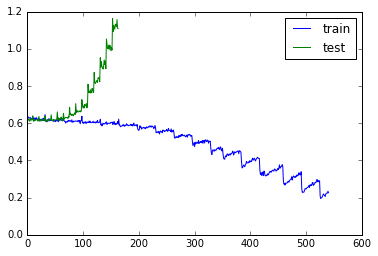

KeyboardInterrupt: 

In [45]:
for epoch in range(5):
    ls_tr = 0.
    ls_val = 0.
    logloss_tr = 0.
    for i, (batch_x, batch_y) in tqdm_notebook(enumerate(iterate_minibatches(train_X, train_y, batch_size))):
        curr_loss = v_train_fn(batch_x, batch_y)
        ls_tr += curr_loss
        
        if i % print_interval == 0 and i > 0:
            all_losses.append(ls_tr / print_interval)
            ls_tr = 0
            
            display.clear_output(wait=True)
            plt.plot(all_losses[1:], label='train')
            plt.plot(v_losses_valid[1:], label='test')
            plt.legend()
            plt.show()
        
    v_losses_train.append(ls_tr/ i)
    
    for i, (batch_x, batch_y) in enumerate(iterate_minibatches(test_X,test_y, batch_size)):
        ls_val += v_test_loss_fn(batch_x, batch_y)
        
        
        if i % print_interval == 0 and i != 0 :
            v_losses_valid.append(ls_val / print_interval)
            ls_val = 0
            display.clear_output(wait=True)
            plt.plot(all_losses[1:], label='train')
            plt.plot(v_losses_valid[1:], label='test')
            plt.legend()
            plt.show()
            
    #lr = lr * 0.98
        
    #tqdm.write(str(ls_val / i))
    
    

In [93]:
lr = 

array(0.00833748)

In [ ]:
test_y[:10].shape

In [ ]:
v_test_loss_fn(test_X[:10000], test_y[:10000])

In [ ]:
for batch_x, batch_y in iterate_minibatches(test_X[:1000],test_y[:1000], 1000):
    print( v_test_loss_fn(batch_x, batch_y))
    

In [46]:
pred = v_prediction.eval({input_X : test_X})

In [78]:
pred_train = v_prediction.eval({input_X : train_X[:200]})

In [48]:
(pred.reshape(-1))[:40]

array([  8.99671972e-01,   9.99038339e-01,   9.99922514e-01,
         1.55260001e-04,   5.80861688e-01,   3.02708954e-01,
         7.23366261e-01,   1.25020836e-03,   6.63624844e-03,
         6.19632751e-02,   6.41687751e-01,   8.72912884e-01,
         7.48454034e-02,   2.35748291e-03,   7.87215292e-01,
         1.72635242e-02,   9.97684360e-01,   1.69399660e-03,
         1.34355724e-02,   1.08491682e-01,   7.39874959e-01,
         8.98698252e-03,   1.07481793e-01,   7.53607035e-01,
         1.73793897e-01,   2.10907161e-01,   6.91883922e-01,
         9.71480086e-02,   5.22320569e-01,   1.32344710e-03,
         9.46442425e-01,   5.26113808e-01,   1.61577854e-02,
         9.13445950e-01,   3.21798772e-03,   2.91917175e-01,
         8.87509942e-01,   1.10552358e-02,   2.86269072e-03,
         5.66236749e-02], dtype=float32)

In [47]:
test_y[:40]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])

In [49]:
f1_score(test_y, pred > 0.5)

0.43584796768076511

In [50]:
accuracy_score(test_y, pred > 0.5)

0.61823943583391916

In [51]:
roc_auc_score(test_y, pred > 0.5)

0.57260398431082948

In [52]:
mask = test_y == 1

In [53]:
mask = test_y == 1
print(mask.sum())
accuracy_score(test_y[mask], pred[mask] > 0.5)


32157


0.41098361165531611

In [54]:
mask = test_y == 0
print(mask.sum())
accuracy_score(test_y[mask], pred[mask] > 0.5)


57462


0.73422435696634303

In [39]:
mask.sum()

57462

In [19]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [21]:
roc_auc_score(test_y, pred > 0.5) 

IndexError: index 1 is out of bounds for axis 1 with size 1

In [49]:
f1_score(test_y, pred_0[:,1] > 0.5) 

0.69188091157239895

In [50]:
accuracy_score(test_y, pred_0[:,1] > 0.5)

0.60186035829122642